In [6]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [7]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [8]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, rewards, dones, rates

In [9]:
def Act(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Act', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [10]:
def Env(states, actions, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Env', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        states_logits = tf.layers.dense(inputs=nl2, units=state_size, trainable=False)
        Qlogits = tf.layers.dense(inputs=nl2, units=1, trainable=False)
        return states_logits, Qlogits

In [11]:
def model_loss(state_size, action_size, hidden_size, gamma,
               states, actions, next_states, rewards, dones, rates):
    ################################################ a = act(s)
    actions_logits = Act(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ################################################ s', r = env(s, a)
    e_next_states_logits, eQs = Env(actions=actions_labels, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size)
    a_next_states_logits, aQs = Env(actions=actions_logits, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size, reuse=True)
    next_states_labels = tf.nn.sigmoid(next_states)
    eloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=e_next_states_logits, # GQN
                                                                   labels=next_states_labels))
    eloss += -tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                     labels=next_states_labels)) # maximize loss
    aloss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                    labels=next_states_labels)) # minimize loss
    eQs_logits = tf.reshape(eQs, shape=[-1])
    aQs_logits = tf.reshape(aQs, shape=[-1])
    #################################################### s'', Q' = ~env(s', ~a')
    next_actions_logits = Act(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    next_states_logits, aQs2 = Env(actions=next_actions_logits, states=next_states, hidden_size=hidden_size, 
                                   action_size=action_size, state_size=state_size, reuse=True)
    aQs2_logits = tf.reshape(aQs2, shape=[-1]) * (1-dones)
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=eQs_logits, # GAN
                                                                    labels=rates)) # 0-1 real
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                    labels=tf.zeros_like(rates))) # min
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                     labels=tf.ones_like(rates))) # max
    ###################################################### Q(s,a)= r + Q'(s',a')
    targetQs = rewards + (gamma * aQs2_logits) # DQN/Qlearning
    eloss += tf.reduce_mean(tf.square(eQs_logits - targetQs)) # real
#     eloss += tf.reduce_mean(tf.square(aQs_logits - rewards)) # min
#     aloss2 += tf.reduce_mean(tf.square(aQs_logits - targetQs)) # max
    eloss += tf.reduce_mean((aQs_logits+aQs2_logits)/2) # min
    aloss2 += -tf.reduce_mean((aQs_logits+aQs2_logits)/2) # max
    return actions_logits, aloss, eloss, aloss2

In [12]:
def model_opt(a_loss, e_loss, a_loss2, a_learning_rate, e_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('Act')]
    e_vars = [var for var in t_vars if var.name.startswith('Env')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        e_opt = tf.train.AdamOptimizer(e_learning_rate).minimize(e_loss, var_list=e_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, e_opt, a_opt2

In [13]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, e_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.e_loss, self.a_loss2 = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, 
            rewards=self.rewards, dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.e_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        e_loss=self.e_loss,
                                                        a_loss2=self.a_loss2, 
                                                        a_learning_rate=a_learning_rate,
                                                        e_learning_rate=e_learning_rate)

In [14]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
#         return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [15]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [16]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
e_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size
gamma=0.99

In [17]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size, gamma=gamma,
              a_learning_rate=a_learning_rate, e_learning_rate=e_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [18]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        #print(done)
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        state = env.reset()
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
aloss_list, eloss_list, aloss2_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes for running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        aloss_batch, eloss_batch, aloss2_batch = [], [], []
        total_reward = 0
        state = env.reset()
        num_step = 0
        rate = -1

        # Training steps/batches
        while True:
            # Explore (env) or Exploit (model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Training with the maxrated minibatch
            batch = memory.buffer
            #for idx in range(memory_size// batch_size):
            while True:
                idx = np.random.choice(np.arange(memory_size// batch_size))
                states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                states = states[rates >= np.max(rates)]
                actions = actions[rates >= np.max(rates)]
                next_states = next_states[rates >= np.max(rates)]
                rewards = rewards[rates >= np.max(rates)]
                dones = dones[rates >= np.max(rates)]
                rates = rates[rates >= np.max(rates)]
                if np.count_nonzero(dones) > 0 and len(dones) > 1 and np.max(rates) > 0:
                    break
            aloss, _ = sess.run([model.a_loss, model.a_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.next_states: next_states,
                                               model.rewards: rewards,
                                               model.dones: dones,
                                               model.rates: rates})
            eloss, _ = sess.run([model.e_loss, model.e_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.next_states: next_states,
                                               model.rewards: rewards,
                                               model.dones: dones,
                                               model.rates: rates})
            aloss2, _= sess.run([model.a_loss2, model.a_opt2], 
                                 feed_dict = {model.states: states, 
                                              model.actions: actions,
                                              model.next_states: next_states,
                                              model.rewards: rewards,
                                              model.dones: dones,
                                              model.rates: rates})
            # print(len(dones), np.count_nonzero(dones), np.max(rates))
            aloss_batch.append(aloss)
            eloss_batch.append(eloss)
            aloss2_batch.append(aloss2)
            if done is True:
                break
                
        # Rating the latest played episode
        rate = total_reward/500 # update rate at the end/ when episode is done
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                memory.buffer[-1-idx][-1] = rate # rate the trajectory/data

        # Print out
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'eloss:{:.4f}'.format(np.mean(eloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        aloss_list.append([ep, np.mean(aloss_batch)])
        eloss_list.append([ep, np.mean(eloss_batch)])
        aloss2_list.append([ep, np.mean(aloss2_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:17.0000 R:17.0000 rate:0.0340 aloss:0.6896 eloss:2.4751 aloss2:1.2802 exploreP:0.9983
Episode:1 meanR:24.5000 R:32.0000 rate:0.0640 aloss:0.6942 eloss:2.4489 aloss2:1.2940 exploreP:0.9952
Episode:2 meanR:21.0000 R:14.0000 rate:0.0280 aloss:0.6883 eloss:2.4082 aloss2:1.3121 exploreP:0.9938
Episode:3 meanR:22.0000 R:25.0000 rate:0.0500 aloss:0.6888 eloss:2.4750 aloss2:1.2864 exploreP:0.9913
Episode:4 meanR:23.2000 R:28.0000 rate:0.0560 aloss:0.6900 eloss:2.4895 aloss2:1.2813 exploreP:0.9886
Episode:5 meanR:25.8333 R:39.0000 rate:0.0780 aloss:0.6926 eloss:2.3605 aloss2:1.3394 exploreP:0.9848
Episode:6 meanR:24.0000 R:13.0000 rate:0.0260 aloss:0.7000 eloss:2.4082 aloss2:1.3171 exploreP:0.9835
Episode:7 meanR:22.7500 R:14.0000 rate:0.0280 aloss:0.6948 eloss:2.3247 aloss2:1.3439 exploreP:0.9821
Episode:8 meanR:26.2222 R:54.0000 rate:0.1080 aloss:0.6982 eloss:2.3858 aloss2:1.3317 exploreP:0.9769
Episode:9 meanR:24.9000 R:13.0000 rate:0.0260 aloss:0.7071 eloss:2.4294 aloss2:1.3

Episode:80 meanR:24.0617 R:17.0000 rate:0.0340 aloss:0.6959 eloss:1.5011 aloss2:2.0661 exploreP:0.8247
Episode:81 meanR:23.9756 R:17.0000 rate:0.0340 aloss:0.7072 eloss:1.4611 aloss2:2.0986 exploreP:0.8233
Episode:82 meanR:23.8554 R:14.0000 rate:0.0280 aloss:0.7250 eloss:1.4323 aloss2:2.1479 exploreP:0.8222
Episode:83 meanR:23.7143 R:12.0000 rate:0.0240 aloss:0.6955 eloss:1.4543 aloss2:2.0872 exploreP:0.8212
Episode:84 meanR:23.9412 R:43.0000 rate:0.0860 aloss:0.7116 eloss:1.4175 aloss2:2.1826 exploreP:0.8177
Episode:85 meanR:23.9651 R:26.0000 rate:0.0520 aloss:0.6966 eloss:1.3783 aloss2:2.2037 exploreP:0.8156
Episode:86 meanR:24.2299 R:47.0000 rate:0.0940 aloss:0.7030 eloss:1.3636 aloss2:2.2205 exploreP:0.8118
Episode:87 meanR:24.2500 R:26.0000 rate:0.0520 aloss:0.7074 eloss:1.3289 aloss2:2.2551 exploreP:0.8098
Episode:88 meanR:24.1348 R:14.0000 rate:0.0280 aloss:0.6975 eloss:1.3721 aloss2:2.2376 exploreP:0.8086
Episode:89 meanR:24.1667 R:27.0000 rate:0.0540 aloss:0.6871 eloss:1.2917 

Episode:159 meanR:33.2500 R:34.0000 rate:0.0680 aloss:0.8236 eloss:-0.1234 aloss2:5.0926 exploreP:0.6304
Episode:160 meanR:33.5500 R:53.0000 rate:0.1060 aloss:0.7847 eloss:-0.1165 aloss2:5.1658 exploreP:0.6271
Episode:161 meanR:33.5700 R:30.0000 rate:0.0600 aloss:0.8447 eloss:-0.0162 aloss2:5.2397 exploreP:0.6252
Episode:162 meanR:33.3600 R:28.0000 rate:0.0560 aloss:0.8015 eloss:-0.2376 aloss2:5.3201 exploreP:0.6235
Episode:163 meanR:33.4900 R:29.0000 rate:0.0580 aloss:0.7972 eloss:-0.2173 aloss2:5.3601 exploreP:0.6217
Episode:164 meanR:33.7000 R:38.0000 rate:0.0760 aloss:0.7925 eloss:-0.2207 aloss2:5.3088 exploreP:0.6194
Episode:165 meanR:33.6400 R:25.0000 rate:0.0500 aloss:0.7655 eloss:-0.2981 aloss2:5.3321 exploreP:0.6179
Episode:166 meanR:33.3100 R:20.0000 rate:0.0400 aloss:0.8006 eloss:-0.2716 aloss2:5.4330 exploreP:0.6167
Episode:167 meanR:33.5500 R:47.0000 rate:0.0940 aloss:0.8132 eloss:-0.3278 aloss2:5.5146 exploreP:0.6138
Episode:168 meanR:33.6700 R:33.0000 rate:0.0660 aloss:0

Episode:237 meanR:48.0600 R:31.0000 rate:0.0620 aloss:0.8209 eloss:-2.4080 aloss2:14.0784 exploreP:0.4345
Episode:238 meanR:47.7400 R:29.0000 rate:0.0580 aloss:0.8241 eloss:-2.6044 aloss2:14.3817 exploreP:0.4332
Episode:239 meanR:47.4500 R:25.0000 rate:0.0500 aloss:0.8798 eloss:-2.2483 aloss2:14.6729 exploreP:0.4322
Episode:240 meanR:46.9500 R:27.0000 rate:0.0540 aloss:0.7962 eloss:-2.9869 aloss2:14.6049 exploreP:0.4310
Episode:241 meanR:47.0300 R:26.0000 rate:0.0520 aloss:0.7732 eloss:-3.2265 aloss2:15.2617 exploreP:0.4299
Episode:242 meanR:46.7600 R:21.0000 rate:0.0420 aloss:0.8273 eloss:-3.1206 aloss2:15.5174 exploreP:0.4291
Episode:243 meanR:46.5500 R:30.0000 rate:0.0600 aloss:0.8267 eloss:-3.2117 aloss2:15.5253 exploreP:0.4278
Episode:244 meanR:46.5200 R:30.0000 rate:0.0600 aloss:0.8184 eloss:-3.1987 aloss2:15.4251 exploreP:0.4265
Episode:245 meanR:46.6900 R:32.0000 rate:0.0640 aloss:0.8146 eloss:-3.3233 aloss2:15.7230 exploreP:0.4252
Episode:246 meanR:46.4400 R:29.0000 rate:0.058

Episode:315 meanR:49.7600 R:72.0000 rate:0.1440 aloss:0.8463 eloss:-5.8744 aloss2:28.2600 exploreP:0.3020
Episode:316 meanR:49.8600 R:63.0000 rate:0.1260 aloss:0.8950 eloss:-5.2196 aloss2:28.8028 exploreP:0.3002
Episode:317 meanR:49.7900 R:54.0000 rate:0.1080 aloss:0.8864 eloss:-5.8187 aloss2:28.6017 exploreP:0.2986
Episode:318 meanR:50.2200 R:84.0000 rate:0.1680 aloss:0.8432 eloss:-5.6885 aloss2:28.7716 exploreP:0.2962
Episode:319 meanR:50.0700 R:40.0000 rate:0.0800 aloss:0.8200 eloss:-5.8704 aloss2:28.8645 exploreP:0.2951
Episode:320 meanR:49.7500 R:47.0000 rate:0.0940 aloss:0.7956 eloss:-5.9162 aloss2:29.1370 exploreP:0.2937
Episode:321 meanR:49.6800 R:59.0000 rate:0.1180 aloss:0.7982 eloss:-4.5912 aloss2:29.2302 exploreP:0.2921
Episode:322 meanR:49.1500 R:30.0000 rate:0.0600 aloss:0.7323 eloss:-5.8171 aloss2:29.2466 exploreP:0.2912
Episode:323 meanR:49.2300 R:43.0000 rate:0.0860 aloss:0.7701 eloss:-6.0045 aloss2:29.7829 exploreP:0.2900
Episode:324 meanR:49.2100 R:65.0000 rate:0.130

Episode:393 meanR:40.1700 R:11.0000 rate:0.0220 aloss:0.7679 eloss:-8.1381 aloss2:41.4583 exploreP:0.2180
Episode:394 meanR:40.0800 R:12.0000 rate:0.0240 aloss:0.7525 eloss:-8.6497 aloss2:38.9943 exploreP:0.2177
Episode:395 meanR:39.9900 R:13.0000 rate:0.0260 aloss:0.7270 eloss:-8.4349 aloss2:38.8401 exploreP:0.2175
Episode:396 meanR:39.8300 R:9.0000 rate:0.0180 aloss:0.7388 eloss:-8.9308 aloss2:39.8086 exploreP:0.2173
Episode:397 meanR:39.6300 R:9.0000 rate:0.0180 aloss:0.7419 eloss:-7.6230 aloss2:38.4143 exploreP:0.2171
Episode:398 meanR:39.6100 R:11.0000 rate:0.0220 aloss:0.7258 eloss:-7.2360 aloss2:39.6960 exploreP:0.2169
Episode:399 meanR:39.5200 R:12.0000 rate:0.0240 aloss:0.7171 eloss:-8.5398 aloss2:38.8740 exploreP:0.2166
Episode:400 meanR:39.4700 R:13.0000 rate:0.0260 aloss:0.7092 eloss:-8.1699 aloss2:38.9544 exploreP:0.2164
Episode:401 meanR:39.4800 R:15.0000 rate:0.0300 aloss:0.7062 eloss:-8.2692 aloss2:40.1306 exploreP:0.2160
Episode:402 meanR:39.3000 R:9.0000 rate:0.0180 a

Episode:471 meanR:26.8600 R:11.0000 rate:0.0220 aloss:0.7493 eloss:-3.6992 aloss2:44.1811 exploreP:0.1728
Episode:472 meanR:26.8400 R:10.0000 rate:0.0200 aloss:0.7053 eloss:-8.3363 aloss2:44.6847 exploreP:0.1727
Episode:473 meanR:26.8200 R:11.0000 rate:0.0220 aloss:0.7334 eloss:-6.0858 aloss2:44.7507 exploreP:0.1725
Episode:474 meanR:26.7700 R:9.0000 rate:0.0180 aloss:0.7131 eloss:-8.6259 aloss2:44.3585 exploreP:0.1724
Episode:475 meanR:26.7500 R:9.0000 rate:0.0180 aloss:0.7276 eloss:-5.0815 aloss2:45.8385 exploreP:0.1722
Episode:476 meanR:26.7500 R:9.0000 rate:0.0180 aloss:0.7071 eloss:-5.8257 aloss2:45.3097 exploreP:0.1721
Episode:477 meanR:26.7300 R:9.0000 rate:0.0180 aloss:0.6825 eloss:-8.7991 aloss2:44.8897 exploreP:0.1719
Episode:478 meanR:26.7500 R:12.0000 rate:0.0240 aloss:0.6925 eloss:-8.0788 aloss2:44.5350 exploreP:0.1717
Episode:479 meanR:26.7300 R:9.0000 rate:0.0180 aloss:0.6887 eloss:-9.2903 aloss2:45.3274 exploreP:0.1716
Episode:480 meanR:26.7400 R:11.0000 rate:0.0220 alo

Episode:549 meanR:60.5800 R:48.0000 rate:0.0960 aloss:0.8700 eloss:-4.9340 aloss2:48.5315 exploreP:0.1008
Episode:550 meanR:60.8200 R:34.0000 rate:0.0680 aloss:0.8333 eloss:-5.8059 aloss2:48.5944 exploreP:0.1005
Episode:551 meanR:61.1200 R:40.0000 rate:0.0800 aloss:0.7670 eloss:-8.2207 aloss2:48.5162 exploreP:0.1002
Episode:552 meanR:61.5000 R:49.0000 rate:0.0980 aloss:0.8530 eloss:-6.5345 aloss2:49.2701 exploreP:0.0997
Episode:553 meanR:61.9100 R:50.0000 rate:0.1000 aloss:0.8321 eloss:-8.0055 aloss2:49.8357 exploreP:0.0993
Episode:554 meanR:62.4300 R:62.0000 rate:0.1240 aloss:0.8357 eloss:-7.1660 aloss2:49.8908 exploreP:0.0987
Episode:555 meanR:62.7600 R:44.0000 rate:0.0880 aloss:0.8232 eloss:-8.7461 aloss2:50.1711 exploreP:0.0983
Episode:556 meanR:62.9600 R:30.0000 rate:0.0600 aloss:0.7456 eloss:-6.9167 aloss2:47.5560 exploreP:0.0981
Episode:557 meanR:63.4000 R:52.0000 rate:0.1040 aloss:0.8290 eloss:-6.1503 aloss2:49.2447 exploreP:0.0976
Episode:558 meanR:63.8400 R:56.0000 rate:0.112

Episode:627 meanR:49.3600 R:79.0000 rate:0.1580 aloss:0.8691 eloss:-8.8900 aloss2:52.7684 exploreP:0.0734
Episode:628 meanR:49.1000 R:48.0000 rate:0.0960 aloss:1.1122 eloss:-3.1515 aloss2:50.4310 exploreP:0.0731
Episode:629 meanR:48.9500 R:35.0000 rate:0.0700 aloss:0.8901 eloss:-8.8920 aloss2:51.4531 exploreP:0.0729
Episode:630 meanR:49.1200 R:53.0000 rate:0.1060 aloss:0.9039 eloss:-8.0612 aloss2:51.2172 exploreP:0.0726
Episode:631 meanR:48.9500 R:50.0000 rate:0.1000 aloss:0.8784 eloss:-8.9791 aloss2:52.8646 exploreP:0.0723
Episode:632 meanR:48.7600 R:41.0000 rate:0.0820 aloss:0.8749 eloss:-9.1640 aloss2:52.6903 exploreP:0.0720
Episode:633 meanR:48.8100 R:48.0000 rate:0.0960 aloss:0.8662 eloss:-8.2313 aloss2:53.0108 exploreP:0.0717
Episode:634 meanR:48.7100 R:30.0000 rate:0.0600 aloss:0.9197 eloss:-8.2466 aloss2:53.0214 exploreP:0.0715
Episode:635 meanR:48.4800 R:40.0000 rate:0.0800 aloss:0.9315 eloss:-7.4664 aloss2:51.7776 exploreP:0.0713
Episode:636 meanR:48.3500 R:30.0000 rate:0.060

Episode:705 meanR:41.8700 R:21.0000 rate:0.0420 aloss:0.9527 eloss:-9.1845 aloss2:54.2891 exploreP:0.0562
Episode:706 meanR:41.9700 R:41.0000 rate:0.0820 aloss:1.0565 eloss:-4.4649 aloss2:54.9687 exploreP:0.0560
Episode:707 meanR:41.9800 R:42.0000 rate:0.0840 aloss:1.0227 eloss:-8.6871 aloss2:53.7658 exploreP:0.0558
Episode:708 meanR:42.0200 R:34.0000 rate:0.0680 aloss:0.9156 eloss:-9.5541 aloss2:53.5077 exploreP:0.0556
Episode:709 meanR:42.0400 R:27.0000 rate:0.0540 aloss:1.0259 eloss:-8.6363 aloss2:53.4774 exploreP:0.0555
Episode:710 meanR:41.9600 R:33.0000 rate:0.0660 aloss:1.0469 eloss:-5.6311 aloss2:53.7847 exploreP:0.0554
Episode:711 meanR:41.9000 R:35.0000 rate:0.0700 aloss:1.0296 eloss:-8.0121 aloss2:52.6096 exploreP:0.0552
Episode:712 meanR:42.0900 R:55.0000 rate:0.1100 aloss:0.9802 eloss:-8.5967 aloss2:53.5755 exploreP:0.0550
Episode:713 meanR:41.9400 R:38.0000 rate:0.0760 aloss:1.0700 eloss:-7.0728 aloss2:55.0741 exploreP:0.0548
Episode:714 meanR:41.7900 R:30.0000 rate:0.060

Episode:783 meanR:76.7100 R:500.0000 rate:1.0000 aloss:0.7161 eloss:-7.6219 aloss2:58.1903 exploreP:0.0331
Episode:784 meanR:81.1700 R:500.0000 rate:1.0000 aloss:0.7105 eloss:-8.6901 aloss2:58.8445 exploreP:0.0320
Episode:785 meanR:85.7100 R:500.0000 rate:1.0000 aloss:0.6935 eloss:-7.2664 aloss2:58.9687 exploreP:0.0309
Episode:786 meanR:89.9100 R:452.0000 rate:0.9040 aloss:0.6907 eloss:-8.3557 aloss2:59.0211 exploreP:0.0300
Episode:787 meanR:94.5200 R:500.0000 rate:1.0000 aloss:0.6830 eloss:-8.2956 aloss2:58.6717 exploreP:0.0290
Episode:788 meanR:99.3500 R:500.0000 rate:1.0000 aloss:0.6929 eloss:-7.7296 aloss2:59.2792 exploreP:0.0281
Episode:789 meanR:104.0800 R:500.0000 rate:1.0000 aloss:0.6825 eloss:-7.2503 aloss2:59.0990 exploreP:0.0272
Episode:790 meanR:108.3100 R:466.0000 rate:0.9320 aloss:0.6592 eloss:-7.2728 aloss2:58.8294 exploreP:0.0264
Episode:791 meanR:111.5800 R:376.0000 rate:0.7520 aloss:0.6653 eloss:-7.5589 aloss2:58.6336 exploreP:0.0258
Episode:792 meanR:114.4800 R:318.0

Episode:860 meanR:281.6400 R:70.0000 rate:0.1400 aloss:0.6433 eloss:-6.7537 aloss2:64.6566 exploreP:0.0121
Episode:861 meanR:282.0800 R:75.0000 rate:0.1500 aloss:0.6123 eloss:-6.7483 aloss2:65.0919 exploreP:0.0121
Episode:862 meanR:284.7600 R:352.0000 rate:0.7040 aloss:0.6558 eloss:-6.0038 aloss2:64.0199 exploreP:0.0120
Episode:863 meanR:289.3900 R:500.0000 rate:1.0000 aloss:0.6158 eloss:-5.2590 aloss2:64.3326 exploreP:0.0119
Episode:864 meanR:290.2700 R:114.0000 rate:0.2280 aloss:0.6472 eloss:-3.6989 aloss2:63.0922 exploreP:0.0119
Episode:865 meanR:290.6900 R:120.0000 rate:0.2400 aloss:0.5815 eloss:-6.6969 aloss2:64.7684 exploreP:0.0119


# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

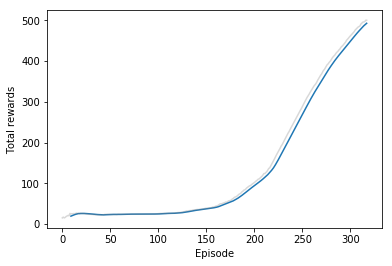

In [22]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

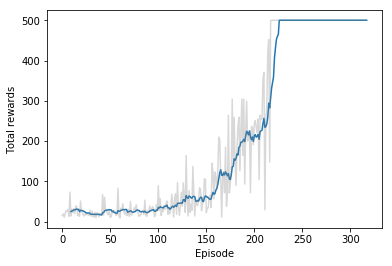

In [23]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Act losses')

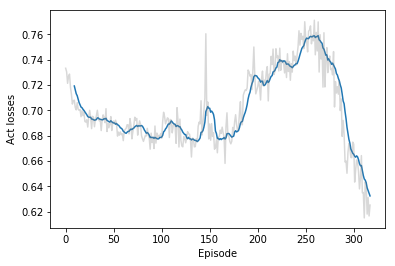

In [24]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Env losses')

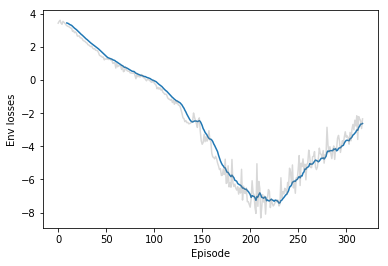

In [25]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Act losses 2')

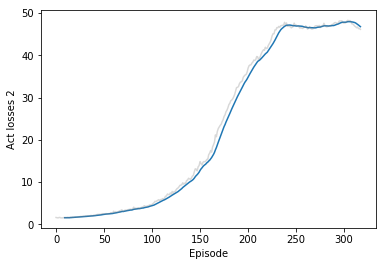

In [26]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

## Testing

Let's checkout how our trained agent plays the game.

In [21]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
